In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


In [147]:
df=pd.io.gbq.read_gbq('SELECT * FROM projekt-zaliczeniowy-401114.movies.movies',project_id='projekt-zaliczeniowy-401114')

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Poster_Link      1000 non-null   object 
 1   Series_Title     1000 non-null   object 
 2   Released_Year    1000 non-null   Int64  
 3   Certificate      899 non-null    object 
 4   IMDB_Rating      1000 non-null   float64
 5   Overview         1000 non-null   object 
 6   Meta_score       843 non-null    float64
 7   Director         1000 non-null   object 
 8   Star1            1000 non-null   object 
 9   Star2            1000 non-null   object 
 10  Star3            1000 non-null   object 
 11  Star4            1000 non-null   object 
 12  No_of_Votes      1000 non-null   Int64  
 13  Gross            831 non-null    float64
 14  Runtime_minutes  1000 non-null   Int64  
 15  Genre1           1000 non-null   object 
 16  Genre2           895 non-null    object 
 17  Genre3         

In [149]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime_minutes,Genre1,Genre2,Genre3
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,142,Drama,None,None
1,https://m.media-amazon.com/images/M/MV5BMmEzNT...,Fight Club,1999,A,8.8,An insomniac office worker and a devil-may-car...,66.0,David Fincher,Brad Pitt,Edward Norton,Meat Loaf,Zach Grenier,1854740,37030102.0,139,Drama,None,None
2,https://m.media-amazon.com/images/M/MV5BZjA0OW...,One Flew Over the Cuckoo's Nest,1975,A,8.7,A criminal pleads insanity and is admitted to ...,83.0,Milos Forman,Jack Nicholson,Louise Fletcher,Michael Berryman,Peter Brocco,918088,112000000.0,133,Drama,None,None
3,https://m.media-amazon.com/images/M/MV5BOTc2ZT...,Soorarai Pottru,2020,U,8.6,"Nedumaaran Rajangam ""Maara"" sets out to make t...",NaN,Sudha Kongara,Suriya,Madhavan,Paresh Rawal,Aparna Balamurali,54995,NaN,153,Drama,None,None
4,https://m.media-amazon.com/images/M/MV5BZjA0MT...,American History X,1998,R,8.5,A former neo-nazi skinhead tries to prevent hi...,62.0,Tony Kaye,Edward Norton,Edward Furlong,Beverly D'Angelo,Jennifer Lien,1034705,6719864.0,119,Drama,None,None


## Which actors appear in TOP 1000 films most frequently?

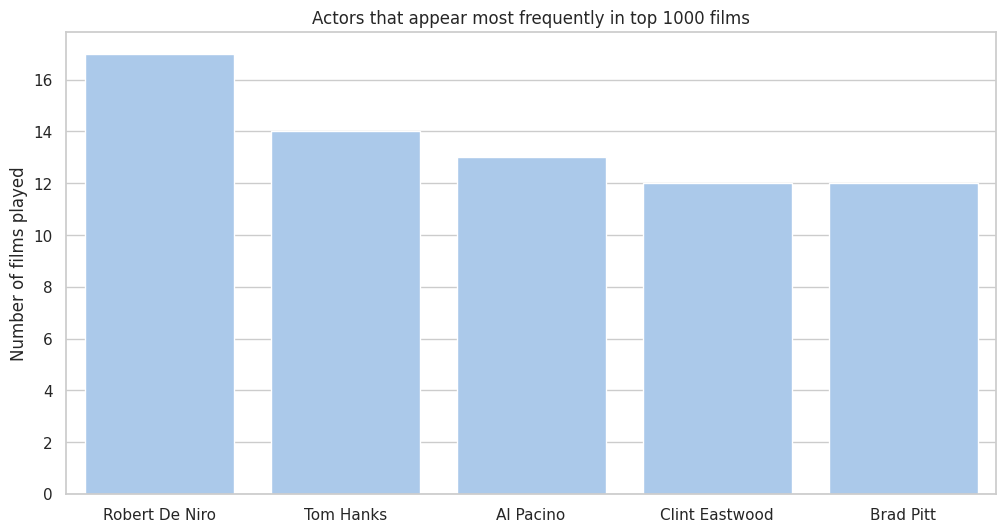

In [150]:
# Define the function
def count_obs(dataframe, *cols):
    """Function to calculate values that appear in columns of dataframe"""
    dict_result = dict()
    for col in cols:
        for obs in dataframe[col]:
            if obs not in dict_result:
                dict_result[obs] = 1
            else:
                dict_result[obs] += 1
    return pd.Series(dict_result).sort_values(ascending = False).head()
# Execute the function on df dataframe
top5_actors = count_obs(df, "Star1", "Star2", "Star3", "Star4")
# Visualization
fig, ax = plt.subplots(figsize = (12,6))
sns.set(style = "whitegrid", palette = "pastel", color_codes = True)
sns.barplot(top5_actors, ax = ax)
ax.set_title("Actors that appear most frequently in top 1000 films")
ax.set_ylabel("Number of films played")
plt.show()

## Outliers analysis

Outlier analysis is the process of identifying outliers, or abnormal observations, in a dataset. Also known as outlier detection, it’s an important step in data analysis, as it removes erroneous or inaccurate observations which might otherwise skew conclusions and bias the results. In our case we will use IQR rule to detect the outliers.

IQR is the range between the first and the third quartiles namely Q1 and Q3: IQR = Q3 – Q1. The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

In [151]:
def outliers_detection(dataframe):
    """ A function that return tuple with dictionary that contains number of outliers for every column and
        a data frame with the value True/False if the observation is an outlier"""
    dframe = dataframe.copy()
    dict_of_outliers = dict()
    df_dict = dict()
    for col in dataframe.columns:
        if dframe[col].dtype != "object":
            dframe[col].fillna(dframe[col].mean(), inplace = True)
            inter_quartile = iqr(dataframe[col])
            lower_boundary = np.quantile(dframe[col], 0.25) - (1.5 * inter_quartile)
            upper_boundary = np.quantile(dframe[col], 0.75) + (1.5 * inter_quartile)
            num_outliers = dframe[col].where((dframe[col] < lower_boundary) | (dframe[col] > upper_boundary)).count()
            dict_of_outliers[col] = num_outliers
            df_dict[col] = ~dframe[col].where((dframe[col] < lower_boundary) | (dframe[col] > upper_boundary)).isna()
    return dict_of_outliers, pd.DataFrame(df_dict)


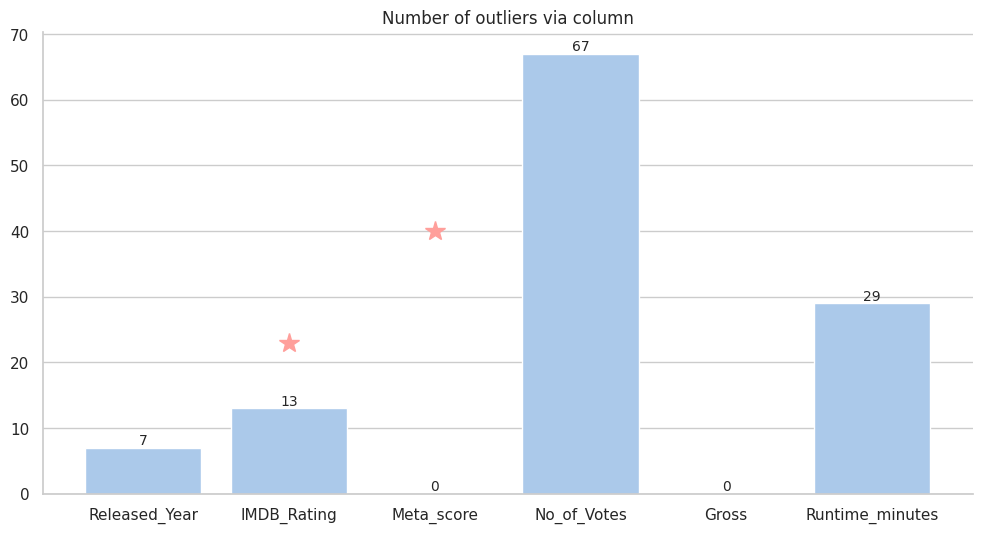

In [152]:
# Execute the function on our initial data frame  
outliers = outliers_detection(df)[0]
# Visualization of the number of outliers
fig, ax = plt.subplots(figsize = (12,6))
sns.set(style = "whitegrid", palette = "pastel", color_codes = True)
sns.despine(top = True, right = True)
sns.barplot(outliers, ax = ax)
ax.set_title("Number of outliers via column")
ax.bar_label(ax.containers[0], fontsize=10)
ax.plot("Meta_score", 40, "*", markersize = 15, color = "r")
ax.plot("IMDB_Rating", 23, "*", markersize=15, color="r")
plt.show()

In this report we will focus on IMDB_Rating and Meta_score outliers. It is important to detect observations which have significantly different ratings. Let's then find observations which are outliers in IMDB_Rating or Meta_score rating.

In [153]:
is_outlier = outliers_detection(df)[1]
outliers_idx = is_outlier.query('(IMDB_Rating == True) | (Meta_score == True)').index
imdb_or_meta_outliers = df.iloc[outliers_idx]
print(f"There are {len(imdb_or_meta_outliers)} outliers!")
display(imdb_or_meta_outliers.head())

There are 13 outliers!


,Poster_Link,Series_Title,Released_Year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime_minutes,Genre1,Genre2,Genre3
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,142,Drama,None,None
1,https://m.media-amazon.com/images/M/MV5BMmEzNT...,Fight Club,1999,A,8.8,An insomniac office worker and a devil-may-car...,66.0,David Fincher,Brad Pitt,Edward Norton,Meat Loaf,Zach Grenier,1854740,37030102.0,139,Drama,None,None
100,https://m.media-amazon.com/images/M/MV5BOTQ5ND...,"Il buono, il brutto, il cattivo",1966,A,8.8,A bounty hunting scam joins two men in an unea...,90.0,Sergio Leone,Clint Eastwood,Eli Wallach,Lee Van Cleef,Aldo Giuffrè,688390,6100000.0,161,Western,None,None
123,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,152,Action,Crime,Drama
207,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,175,Crime,Drama,None


We will visualize the outliers among all observations on a IMDB_rating - Meta_score scatter plot.

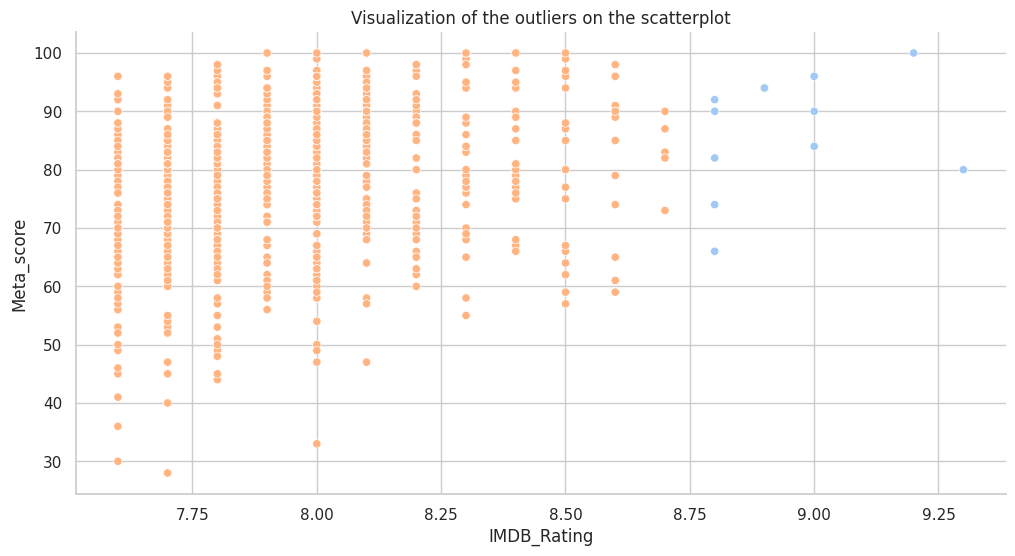

In [154]:
# Creating a list of colors for the plot
colors = list()
for idx in list(df.index):
    if idx not in outliers_idx:
        colors.append("black")
    else:
        colors.append("red")
# Visualization
fig, ax = plt.subplots(figsize = (12,6))
sns.set(style = "whitegrid", palette = "pastel", color_codes = True)
sns.despine(top = True, right = True)
sns.scatterplot(data = df, x = "IMDB_Rating", y = "Meta_score", hue = colors, ax = ax, legend = False)
ax.set_title("Visualization of the outliers on the scatterplot")
plt.show()

Below we mention descriptive statistics of the IMDB_rating and Meta_rating outliers. We can see that mean runtime of the films which are taken as outliers is around 132 minutes. When we move onto the ratings we can see that minimum Meta_score rating is 28.0 (maximum 100.0), whereas for IMDB_Rating minimum is 7.6 (maximum 9.3). We can also observe that the films were released in years between 1957 and 2019, whereas at least 50% of them were released in 2001 year or before.

In [155]:
imdb_or_meta_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
Released_Year,13.0,1989.615385,16.820317,1957.0,1974.0,1994.0,2001.0,2010.0
IMDB_Rating,13.0,8.938462,0.160927,8.8,8.8,8.9,9.0,9.3
Meta_score,13.0,87.384615,9.708574,66.0,82.0,90.0,94.0,100.0
No_of_Votes,13.0,1603833.153846,536987.991924,688390.0,1213505.0,1661481.0,1854740.0,2343110.0
Gross,13.0,178769464.461538,171363170.633843,4360000.0,37030102.0,107928762.0,315544750.0,534858444.0
Runtime_minutes,13.0,160.384615,29.78685,96.0,142.0,154.0,178.0,202.0


The outliers are mostly drama type (34 out of 44 observations). Second type of genre that appears most frequently is Crime (16 out of 44 observations).

In [156]:
# Execute the function on outliers dataset
count_obs(imdb_or_meta_outliers, "Genre1", "Genre2", "Genre3")

Drama        11
None         11
Crime         5
Action        4
Adventure     3
dtype: int64

## Clustering 

The next step to gather insights from the data will be clustering algorithm using KMeans.  
For the clustering we will use only numeric columns from the initial data set:
- Released_Year
- IMDB_Rating
- Meta_score
- No_of_Votes
- Gross
- Runtime_minutes  
  
Before the clustering it is important to deal with outliers and NAs

In [157]:
# Define the data set with conaining numeric columns from initial data set
df_numeric = df[["Released_Year", "IMDB_Rating", "Meta_score", "No_of_Votes", "Gross", "Runtime_minutes"]]
print(f"Number of missing values before: {df_numeric.isna().sum().sum()}")
#-------------------------------------
# We will input the NA with mean value
#-------------------------------------
# Define the function
def na_mean_inputation(dataframe):
    """Input NA values in every column with the mean"""
    for col in dataframe.columns:
        dataframe[col].fillna(dataframe[col].mean(), inplace = True)
# Execute the function
na_mean_inputation(df_numeric)
print(f"Number of missing values after: {df_numeric.isna().sum().sum()}")

Number of missing values before: 326
Number of missing values after: 0


/tmp/ipykernel_1806/647062898.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col].fillna(dataframe[col].mean(), inplace = True)


We observed that there are 99 observations that have outlier in one of the variables. We will drop all of those observations. Now we will work with 901 observations left.

In [180]:
# Data set without NAs and outliers
df_clean = df_numeric[~is_outlier.T.any()]

Next step before clustering is standardization of the data. The data must be standardized because variance of the variable influences power of the variable in clustering. To provide that every variable will have the same influence on the clustering, we have to standardize the data.

In [183]:
scaler = StandardScaler()
df_clean_standardized = scaler.fit_transform(df_clean)

### KMeans optimal number of clusters specification

### Inertia

In KMeans clustering technique we have to specify number of clusters apriori. In this report we will base on cluster inertia to find optimal number of clusters. The lower inertia the better. As a first step we plot inertia for different number of clusters (1-10). Then based on "elbow" method 5 clusters are chosen as an optimal number.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 1

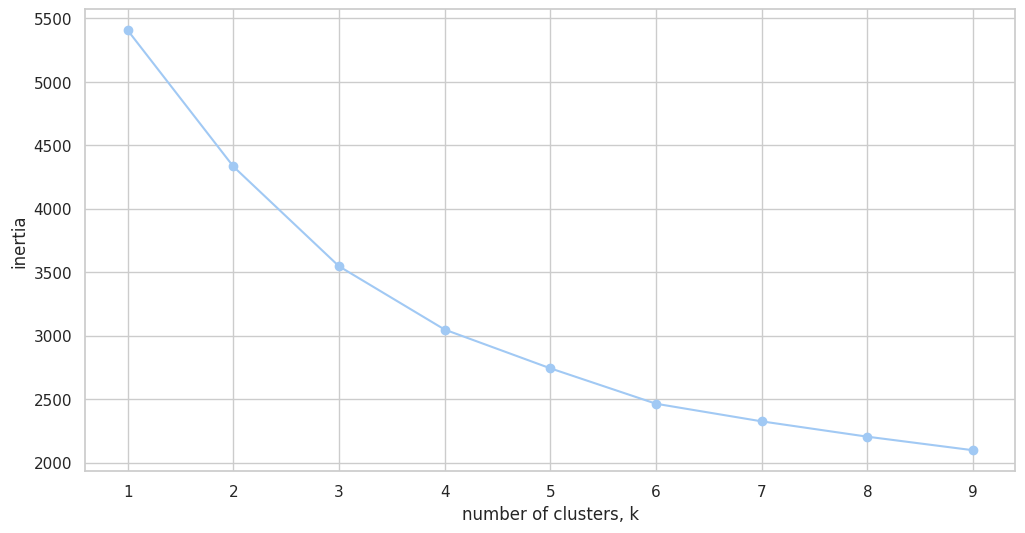

In [189]:
ks = range(1, 10)
inertias = list()
for k in ks:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_clean_standardized)
    inertias.append(kmeans.inertia_)
# Plot of inertia for different number of clusters
plt.figure(figsize=(12,6))
plt.plot(ks, inertias, "-o")
plt.xlabel("number of clusters, k")
plt.ylabel("inertia")
plt.xticks(ks)
plt.show()

We may also use t-SNE dimension reduction method to "glimpse" at the data before choosing optimal number of clusters. Specifically, it models each high-dimensional object by a two dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. If we choose a point and there are some points in the proximity of the point, the points are similar to each other in the input space (high dimensional space).

### t-SNE

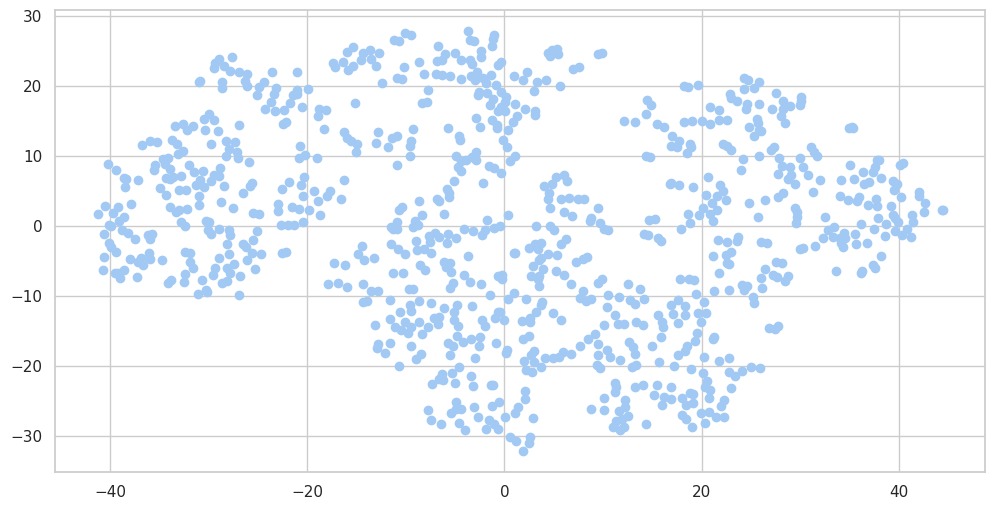

In [188]:
visual_model = TSNE(learning_rate=50)
transformed = visual_model.fit_transform(df_clean_standardized)
xs = transformed[:, 0]
ys = transformed[:, 1]
plt.figure(figsize= (12,6))
plt.scatter(xs, ys)
plt.show()

**Based on the inertia and t-SNE it might be rational to go for 3 clusters as an optimal number.**

## KMeans

In [196]:
kmeans3 = KMeans(n_clusters = 3)
kmeans3.fit(df_clean_standardized)
kmeans_model = kmeans3.transform(df_clean_standardized)
labels = kmeans3.predict(df_clean_standardized)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We can go back to t-SNE plot to see how the KMeans clustering performed. The glimpse on the data set in 2-dimensional plot using t-SNE gave us exact information how the clusters might be formed. Based on KMeans algorithm the aggregation of the points exactly matches to the obtained clusters, whereas small congries were grouped into one cluster

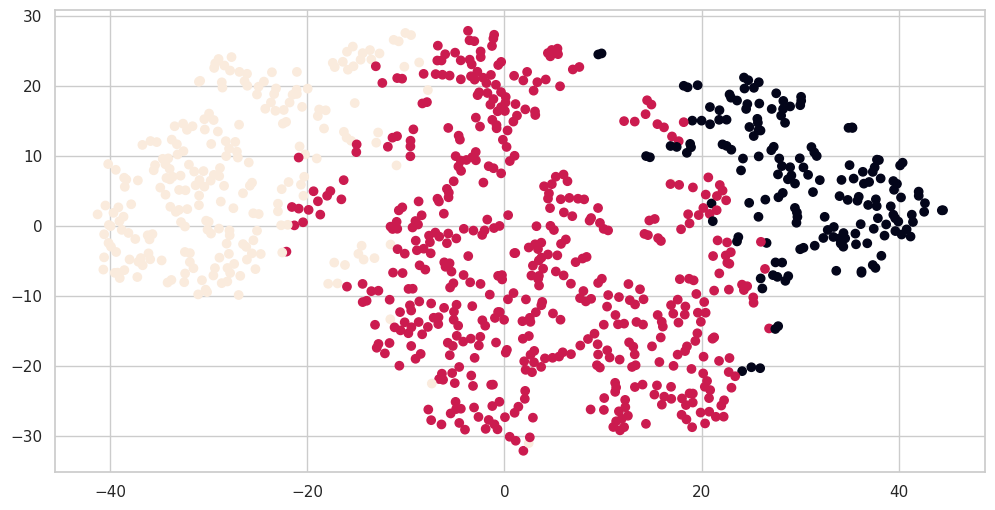

In [197]:
# t-SNE plot with assigned clusters by KMeans
plt.figure(figsize=(12,6))
plt.scatter(xs,ys, c = labels)
plt.show()

## Clusters analysis